# Partial RDF Schema Retrieval
### Master's Thesis
### Author: Koray Poyraz

# Required Libraries

Installer of the required libraries

In [ ]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install seaborn
!pip install matplotlib
!pip install SPARQLWrapper
!pip install pyvis
!pip install sklearn
!pip install umap
!pip install hdbscan
!pip install dask
!pip install simhash

Importing the required libraries

In [2]:
import numpy as np
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import hdbscan
import time
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cosine
import umap
import dask.dataframe as dd
from simhash import Simhash
import matplotlib.pyplot as plt

## Methods

In [3]:
class Node:
    def __init__(self, id, label=None):
        """
        Node structure
        :param id: ID of the node
        :param label: label of the node
        """
        self.id = id
        self.label = label if label else ''
        self.class_type = '' #<-- implicit or explicit class type
        self.class_overlaps = [] #<-- stores the explicit class type overlaps that represent the same pattern
        self.properties = [] #<-- attributes of the node
        self.out_edge = [] #<-- outgoing edges of the node
        self.in_edge = [] #<-- incoming edges of the node

    def __str__(self):
        return f"id={self.id}, label={self.label}, classtype={self.class_type}, classoverlaps={self.class_overlaps}"

    def toJSON(self):
        """
        serialization to JSON
        :return: JSON structure
        """
        return json.dumps(self, default=lambda o: o.__dict__,
            sort_keys=True, indent=4)


class Edge:
    def __init__(self, id, to_node, label=None):
        """
        Edge structure
        :param id: ID of the edge
        :param to_node: relation to Node
        :param label: label of the edge
        """
        self.id = id
        self.label = label if label else ''
        self.to_node = to_node

    def __str__(self):
        return f"{self.id} - {self.label} - {self.to_node}"

In [35]:
def generate_clusters_s(embeddings, min_cluster_size, distance_metric):
    """
    Computes the HDBSCAN clustering algorithm
    :param embeddings: numerical representation
    :param min_cluster_size: minimum cluster size
    :param distance_metric: distance metric for measuring the distance
    :return: clustering solution
    """
    clusterer = hdbscan.HDBSCAN(
        cluster_selection_epsilon=0.0,
        min_cluster_size=min_cluster_size,
        metric=distance_metric,
        cluster_selection_method='leaf',
        gen_min_span_tree=True,
        core_dist_n_jobs=-1
    )

    clusterer.fit(embeddings)

    return clusterer


def calculate_DBCV(model):
    """
    Calculates the relative DBCV
    :param model: clustering solution
    :return: relative validation
    """
    return model.relative_validity_


def automatic_model_selection_s(embeddings, distance_metric):
    """
    (5) operation
    Computes hyperparameter tuning
    :param embeddings: numerical representation
    :param distance_metric: distance metric for measuring the distance
    :return: best model statistical information, clustering solution with highest DBCV score
    """
    epsilon = 0.0
    min_cluster_size = [3, 10, 15, 20]
    cluster_model = None
    dbcv_score = 0
    best_result = None
    validity_index = 0

    print('-------------- Clustering')
    print('Stats: eps, min_cluster_size, dbcv, labels, outliers')
    for i, min_cluster in enumerate(min_cluster_size):
        clusters = generate_clusters_s(embeddings,
                                     min_cluster_size = min_cluster,
                                     distance_metric = distance_metric)

        label_count = len(np.unique(clusters.labels_))

        current_score = calculate_DBCV(clusters)
        current_score = 0 if np.isnan(current_score) else current_score

        db_score = hdbscan.validity_index(embeddings, clusters.labels_, metric=distance_metric)
        db_score = 0 if np.isnan(db_score) else db_score

        outliers = len(clusters.labels_[clusters.labels_ == -1])

        current_stats = [epsilon, min_cluster, current_score, label_count, outliers, db_score]

        if i == 0:
            dbcv_score = current_score
            cluster_model = clusters
            best_result = current_stats
            validity_index = db_score
        elif dbcv_score < current_score:
            dbcv_score = current_score
            cluster_model = clusters
            best_result = current_stats
            validity_index = db_score

        print(f'Stats: {[epsilon, min_cluster, current_score, label_count, outliers, validity_index]}')

    print('Best Stats: eps, min cluster size, dbcv, labels, outliers')
    print(f'Best Stats: {best_result}')

    return best_result, cluster_model

In [2]:
def get_graph(endpoint, query):
    """
    Query statement executor

    :param endpoint: SPARQL-endpoint
    :param query: query statement
    :return: query result (triples)
    """
    user_agent = "Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) Gecko/20100101 Firefox/47.0"
    sparql = SPARQLWrapper(endpoint, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    # Try catch, to continue retrieving triples when request error occurs
    try:
        afterQuery = sparql.query()
        results = afterQuery.convert()
        return [result for result in results["results"]["bindings"]]
    except Exception as e:
        print(f'Request error occurred, but the retrieval process will continue')
        return []


def get_clean_label(predicate):
    """
    Predicate cleaner

    :param predicate: predicate URI
    :return: label of the predicate
    """
    label = predicate.split('/')[-1] if 'http' in predicate else predicate
    return label.split('#')[-1] if '#' in label else label


def is_literal(o_type):
    """
    Checks for literal type

    :param o_type: OBJECT component of the triple
    :return: boolean
    """
    return 'literal' in o_type.lower()


def is_primitive(p):
    """
    Checks for primitive type that refers to a explicit class type

    :param p: PREDICATE component of the triple
    :return: boolean
    """
    return 'rdf' in p.lower() or 'classoverlap' in p.lower()


def is_primitive_type(p):
    """
    Checks for primitive type

    :param p: PREDICATE component of the triple
    :return: boolean
    """
    property = p.lower()
    return 'rdf' in property and 'type' in property


def is_primitive_label(p):
    """
    Checks for primitive type label

    :param p: PREDICATE component of the triple
    :return: boolean
    """
    property = p.lower()
    return 'rdf' in property and 'label' in property

def is_primitive_subClassOf(p):
    """
    Checks for primitive subClassOf relation

    :param p: PREDICATE component of the triple
    :return: boolean
    """
    property = p.lower()
    return 'rdf' in property and 'subClassOf' in property


def annotate_fact(o_type, p):
    """
    (2) operation, step 2. Applies the annotation step

    :param o_type: OBJECT component of the triple
    :param p: PREDICATE component of the triple
    :return: annotated version along with the fact
    """
    new_p = ''
    fact_type = ''

    if is_literal(o_type) and not is_primitive(p):
        new_p = p
    elif is_primitive_label(p):
        new_p = f'{p}-label'
        fact_type = 'label'
    elif is_primitive_type(p):
        new_p = f'{p}-class'
        fact_type = 'class'
    else:
        new_p = f'{p}-out'
        fact_type = 'out'

    return new_p, fact_type


def get_out_edges(endpoint, class_types, window):
    """
    Retrieval process for retrieving the outgoing triples

    :param endpoint: SPARQL-endpoint
    :param class_types: batch consisting of explicit class types
    :param window: sliding window size
    :return: outgoing triples, triple count, class types of the entities, query count
    """
    pointer = 0
    # store an entity
    triple_batch = {}
    # keep track of the related class type of an entity
    class_types_of_entities = []
    triple_count = 0
    num_queries = 0
    running = True

    # Running the retrieval process until all triples are retrieved
    while running:
        q = "select distinct ?c ?s ?p ?o where { "
        q += "VALUES (?c) { " + class_types + " } "
        if window:
            q += "?s a ?c . ?s ?p ?o . } offset " + str(pointer) + " limit " + str(window)
        else:
            q += "?s a ?c . ?s ?p ?o . } offset " + str(pointer)

        triples = get_graph(endpoint, q)
        L = len(triples)

        if L == 0:
            # the retrieving process stops when there is no result anymore, meaning all triples are retrieved
            running = False
            break

        num_queries += 1

        for triple in triples:
            triple_count += 1
            c = triple['c']['value']
            s = triple['s']['value']
            p = triple['p']['value']
            o_type = triple['o']['type']
            o = triple['o']['value']

            if s in triple_batch:
                new_p, fact_type = annotate_fact(o_type, p)

                if new_p not in triple_batch[s]:
                    triple_batch[s].add(new_p)

                if fact_type == 'class':
                    triple_batch[s].add(f'{o}-classoverlap')

            else:
                new_p, fact_type = annotate_fact(o_type, p)
                triple_batch[s] = {new_p}
                class_types_of_entities.append(c)

                if fact_type == 'class':
                    triple_batch[s].add(f'{o}-classoverlap')

        pointer = triple_count

    return triple_batch, triple_count, class_types_of_entities, num_queries


def get_in_edges(endpoint, triple_batch, class_types, window):
    """
    Retrieval process for retrieving the incoming triples

    :param endpoint: SPARQL-endpoint
    :param triple_batch: Using the triple batch obtained after retrieving the outgoing triples, so we dont have to create another collection in the memory
    :param class_types: batch consisting of explicit class types
    :param window: sliding window size
    :return: incoming triples, triple count, query count
    """
    pointer = 0
    running = True
    triple_count = 0
    num_queries = 0

    while running:
        q = "select distinct ?c ?o ?p ?s where { "
        q += "VALUES (?c) { " + class_types + " } "
        q += "?o a ?c . ?s ?p ?o . } offset " + str(pointer) + " limit " + str(window)

        triples = get_graph(endpoint, q)
        L = len(triples)

        # in order to exist the execution when no result
        if L == 0:
            running = False
            break

        num_queries += 1

        for triple in triples:
            triple_count += 1
            p = triple['p']['value']
            entity = triple['o']['value']

            if entity in triple_batch:
                new_p = f'{p}-in'
                if new_p not in triple_batch[entity]:
                    triple_batch[entity].add(new_p)

        pointer = triple_count

    return triple_batch, triple_count, num_queries



def retrieve_triples_from_class_layer(endpoint, class_types, window):
    """
    (2) operation, step 1

    :param endpoint: SPARQL-endpoint
    :param class_types: batch consisting of explicit class types
    :param window: sliding window size
    :return: entities with outgoing and incoming triples
    """
    # class_uri eg a address of a class type
    print('-- Retrieving outgoing edges')
    triple_batch_out_edge, out_triple_count, class_types_of_entities, out_num_queries = get_out_edges(endpoint, class_types, window)

    print('-- Retrieving ingoing edges')
    triple_batch_both_edges, in_triple_count, in_num_queries = get_in_edges(endpoint, triple_batch_out_edge, class_types, window)

    total_triple_count = out_triple_count + in_triple_count
    total_num_queries = out_num_queries + in_num_queries

    return triple_batch_both_edges, total_triple_count, class_types_of_entities, total_num_queries


def remove_similar_properties_pair(properties):
    """
    Similar predicate remover. e.g. building and building.out occur, however, they are the same for example in WikiData

    :param properties: predicate set
    :return: new predicate set, number of removed triples
    """

    new_props = []

    for property in properties:
        has_out = 'out' in property

        if not has_out:
            new_props.append(property)
            continue

        target = property.split('-')[0]
        status = target in properties

        if status:
            continue
        else:
            new_props.append(property)

    # for completeness metrics
    removed_triples = len(properties) - len(new_props)

    return new_props, removed_triples


def discover_patterns_layer(batch):
    """
    (2) operation, step 3 Applying pattern discovery.

    :param batch: batch consisting of entities
    :return: patterns, primitive types, total removed triples
    """

    patterns = []
    primitive = []
    total_removed_triples = 0

    for entity in batch:
        predicates = batch[entity]
        cs_u_d = set([get_clean_label(p) for p in predicates if not is_primitive(p)])
        cs_u_d, removed_triples = remove_similar_properties_pair(cs_u_d)
        total_removed_triples += removed_triples
        cs_u_d = sorted(cs_u_d)
        cs_u_pattern = tuple(cs_u_d)

        cs_p_d = [get_clean_label(p) for p in predicates if is_primitive(p)]
        cs_p_d.sort()

        patterns.append(cs_u_pattern)
        primitive.append(cs_p_d)

    return patterns, primitive, total_removed_triples


def retrieval_of_class_types(endpoint, window):
    """
    Phase (1), method (1), retrieving the fundamental hierarchical structure

    :param endpoint: SPARQL-endpoint
    :param window: sliding window size
    :return: fundamental hierarchical structure, triple count
    """
    pointer = 0
    class_type_map = {}
    predicate_visited = set()
    triple_count = 0
    running = True

    while running:

        q = "PREFIX owl: <http://www.w3.org/2002/07/owl#> SELECT DISTINCT ?c ?p ?o WHERE { ?c a owl:Class . ?c ?p ?o . } "
        q += "offset " + str(pointer) + " limit " + str(window)

        triples = get_graph(endpoint, q)

        L = len(triples)

        if L == 0:
            running = False
            break

        # transformation RDF schema to property graph as initial structure
        for triple in triples:
            triple_count += 1
            c = triple['c']['value']
            p = triple['p']['value']
            o_type = triple['o']['type']
            o = triple['o']['value']

            class_label = get_clean_label(c)
            edge_label = get_clean_label(p)
            edge = None

            if class_label in class_type_map:
                node = class_type_map[class_label]
                if is_primitive_subClassOf(p):
                    super_class = get_clean_label(o)
                    edge_id=f'{class_label}X{super_class}'

                    if edge_id not in predicate_visited:
                        edge = Edge(id=edge_id, label='subClassOf', to_node=super_class)
                        node.out_edge.append(edge)
                        predicate_visited.add(edge_id)
                elif is_literal(o_type) or is_primitive_type(p):
                    if edge_label not in node.properties:
                        node.properties.append(edge_label)
                else:
                    out_edge = get_clean_label(o)
                    edge_id = f'{class_label}X{out_edge}'

                    if edge_id not in predicate_visited:
                        edge = Edge(id=edge_id, label=edge_label, to_node=out_edge)
                        node.out_edge.append(edge)
                        predicate_visited.add(edge_id)
            else:
                node = Node(id=class_label, label=class_label)
                if is_primitive_subClassOf(p):
                    super_class = get_clean_label(o)
                    edge_id = f'{class_label}X{super_class}'
                    edge = Edge(id=edge_id, label='subClassOf', to_node=super_class)
                    node.out_edge.append(edge)
                    predicate_visited.add(edge_id)
                elif is_literal(o_type) or is_primitive_type(p):
                    node.properties.append(edge_label)
                else:
                    out_edge = get_clean_label(o)
                    edge_id = f'{class_label}X{out_edge}'

                    edge = Edge(id=edge_id, label=edge_label, to_node=out_edge)
                    node.out_edge.append(edge)
                    predicate_visited.add(edge_id)

                node.class_type = 'explicit'
                class_type_map[class_label] = node

        pointer = triple_count

    set_classes = None
    predicate_visited = None

    return class_type_map, triple_count


def merge_all_properties(cs_sets, allow_dups=False):
    """
    Flattening 2d-array to 1d-array to have a list of patterns

    :param cs_sets: property sets
    :param allow_dups: determine to keep or not to keep duplicate properties
    :return: flattened array
    """
    flattened = [prop for cs_set in cs_sets for prop in cs_set] if allow_dups else set([prop for cs_set in cs_sets for prop in cs_set])
    return flattened


def find_leafs(explicit_classes, subgraph, predicate='subClassOf'):
    """
    Computes assigning the cluster to a leaf of a subgraph.

    :param explicit_classes: explicit classes that exist within the fundamental hierarchical structure
    :param subgraph: explicit classes that exist within the subgraph that is represented by a cluster
    :param predicate: subClassOf predicate
    :return: the explicit class to assign the cluster, e.g. Given Artist -> Person, then C1 -> Artist
    """
    pairs = set()
    explicit_class_nodes = set()

    for k, v in explicit_classes.items():
        if v.label not in subgraph:
            continue

        for out_edge in v.out_edge:
            if out_edge.label == predicate and out_edge.to_node in subgraph:
                pairs.add((out_edge.to_node, k))
                explicit_class_nodes.add(v)

    from_class = set()
    to_subclass = set()

    for general_class, specific_class in pairs:
        from_class.add(general_class)
        to_subclass.add(specific_class)

    return to_subclass.difference(from_class), explicit_class_nodes


def vectorization_layer(patterns_map):
    """
    (3) operation, Computes vectorization

    :param patterns_map:
    :return:
    """
    entity_patterns = [' '.join(pattern).lower() for pattern in patterns_map]
    allow_annotations = r"(?u)\b[\w-]+\b"

    vectorizer = CountVectorizer(lowercase=False, binary=True, token_pattern=allow_annotations)
    embedding_matrix = vectorizer.fit_transform(entity_patterns)

    return embedding_matrix.toarray()


def dimension_reduction_layer(embedding_matrix):
    """
    (4) operation, Computes dimension reduction

    :param embedding_matrix: numerical representation
    :return: reduced numerical representation
    """
    threshold = 70
    embeddings = None

    if len(embedding_matrix[0]) >= threshold:
        init = 'random' if len(embedding_matrix[0]) > len(embedding_matrix) else 'spectral'
        embeddings = umap.UMAP(metric='cosine', random_state=42, n_jobs=-1, n_components=threshold, init=init).fit_transform(embedding_matrix)
    else:
        embeddings = embedding_matrix

    return embeddings


def compute_clustering_layer(embeddings, distance_metric):
    """
    (5) operation, Computes the automatic selection of the model

    :param embeddings: numerical representation
    :param distance_metric: distance metric, e.g. cosine distance
    :return: stats, clustering solution
    """

    stats, model = automatic_model_selection_s(embeddings, distance_metric)
    return stats, model


def mutate_clustering_result_parallelized_layer(cluster_model, patterns_map, primitive_map, class_label_x_patterns):
    """
    (6) operation, method (1), Groups by cluster label and ungroups outlier cluster

    :param cluster_model: clustering solution
    :param patterns_map: patterns
    :param primitive_map: primitive types
    :param class_label_x_patterns: class labels from the batch
    :return: grouped patterns, outliers
    """

    data = pd.DataFrame({
        'clusterId': cluster_model.labels_,
        'pattern': patterns_map,
        'primi': primitive_map,
        'class_label': class_label_x_patterns,
    })

    dd_clustering_result = dd.from_pandas(data, npartitions=len(data.keys()))

    overlaps_series = dd_clustering_result['primi']
    properties_series = dd_clustering_result['pattern']

    overlaps = overlaps_series.apply(lambda x: [y for y in x if 'classoverlap' in y], meta=overlaps_series)
    primitives = overlaps_series.apply(lambda x: [y for y in x if not 'classoverlap' in y], meta=overlaps_series)
    attributes = properties_series.apply(lambda x: [y for y in x if y.split('-')[-1] not in ['out', 'in']], meta=properties_series)

    dd_clustering_result['classoverlap'] = overlaps.compute()
    dd_clustering_result['primitive'] = primitives.compute()
    dd_clustering_result['attributes'] = attributes.compute()

    dd_clustering_result = dd_clustering_result.drop(columns=['primi'])

    outliers = dd_clustering_result[dd_clustering_result['clusterId'] == -1].compute()

    L_outliers = len(outliers)
    distinct_outliers = {}

    for x in range(L_outliers):
        implicit_class = outliers.iloc[x, :]
        distinct_outliers[implicit_class['pattern']] = implicit_class

    if len(distinct_outliers) > 0:
        outliers = pd.DataFrame(distinct_outliers.values())

    clusters = dd_clustering_result[dd_clustering_result['clusterId'] != -1]

    grouped_clusters = clusters.groupby('clusterId').agg(list).reset_index().compute()

    return grouped_clusters, outliers


def transform_to_property_graph_layer(batch_i, cluster_data, class_type_map):
    """
    (6) operation, method (2), Constructs the nodes along with hierarchical linking to produce a partial schema

    :param batch_i: ith batch
    :param cluster_data: the grouped patterns, outliers
    :param class_type_map: fundamental hierarchical structure
    :return: set of nodes representing partial schema, ready to be produced
    """

    L = len(cluster_data)
    property_graph = []
    allow_dups=False

    for x in range(L):
        implicit_class = cluster_data.iloc[x,:]
        cluster_id = implicit_class['clusterId']

        properties = None
        primitives = None
        attributes = None
        class_overlap = None
        class_label = None

        if cluster_id > -1:
            properties = merge_all_properties(implicit_class['pattern'], allow_dups=allow_dups)
            primitives = merge_all_properties(implicit_class['primitive'], allow_dups=allow_dups)
            attributes = merge_all_properties(implicit_class['attributes'], allow_dups=allow_dups)
            class_overlap = merge_all_properties(implicit_class['classoverlap'], allow_dups=allow_dups)
        else:
            properties = set(implicit_class['pattern'])
            primitives = set(implicit_class['primitive'])
            attributes = set(implicit_class['attributes'])
            class_overlap = set(implicit_class['classoverlap'])

        class_label = implicit_class['class_label']

        class_overlap = set([x.split('-')[0] for x in class_overlap])

        class_overlap_leafs = set()
        explicit_subgraph_nodes = set()

        if len(class_overlap) > 1:
            class_overlap_leafs, explicit_class_nodes = find_leafs(class_type_map, class_overlap)
            explicit_subgraph_nodes = explicit_class_nodes
        elif len(class_overlap) == 1:
            class_overlap_leafs = class_overlap
            overlapping_class = class_overlap.pop()

            if overlapping_class in class_type_map:
                explicit_subgraph_nodes.add(class_type_map[overlapping_class])

        if len(class_overlap) == 0 or len(class_overlap_leafs) == 0:
            fallback_classes = None
            if type(class_label) == list:
                fallback_classes = [get_clean_label(x) for x in class_label]
            else:
                fallback_classes = [get_clean_label(class_label)]

            count_classes = Counter(fallback_classes)
            has_same_freq = sum(count_classes.values()) == len(fallback_classes)
            most_common_classes = None

            if has_same_freq:
                most_common_classes = list(count_classes.keys())
            else:
                most_common_classes = [count_classes.most_common(1).pop()[0]]

            for common_class in most_common_classes:
                class_overlap_leafs.add(common_class)
                if common_class in class_type_map:
                    property_graph.append(class_type_map[common_class])


        label = f'P{batch_i}-C{x}' if cluster_id > -1 else f'P{batch_i}-C{x}-O'

        out_going_edge = [Edge(id=f'{label}X{p}', label=p.split('-')[0], to_node=p) for p in properties if 'out' == p.split('-')[-1]]
        out_going_edge += [Edge(id=f'{label}X{class_label}', label='type', to_node=get_clean_label(class_label)) for class_label in class_overlap_leafs]

        in_going_edge = [Edge(id=f'{p}X{label}', label=p.split('-')[0], to_node=p) for p in properties if 'in' == p.split('-')[-1]]

        all_properties = list(attributes.union(primitives))
        hashy = Simhash(''.join([e.label for e in out_going_edge] + [e.label for e in in_going_edge] + all_properties)).value

        # constructing the nodes
        node = Node(id=hashy, label=label)
        node.properties = all_properties
        node.out_edge = out_going_edge
        node.in_edge = in_going_edge
        node.class_type = 'implicit'
        node.class_overlaps = list(class_overlap_leafs)

        property_graph.append(node)

        for explicit_class_node in explicit_subgraph_nodes:
            property_graph.append(explicit_class_node)

    return property_graph


In [37]:
def partitioning(class_types_x_freq_instances, batch_size=2000):
    """
    Applying partitioning based on class type sizes

    :param class_types_x_freq_instances: class type with the size
    :param batch_size: batch size
    :return: set of batches
    """
    class_partitions = {}
    partition_index = 0
    size = 0
    class_partitions[partition_index] = []

    for k, v in class_types_x_freq_instances.items():

        if size+v <= batch_size:
            if partition_index in class_partitions:
                class_partitions[partition_index].append(k)
            else:
                class_partitions[partition_index] = [k]
            size += v
        elif v >= batch_size:
            if partition_index != 0:
                partition_index += 1
            class_partitions[partition_index] = [k]
            partition_index += 1
            size = 0
        else:
            partition_index += 1
            class_partitions[partition_index] = [k]
            size = v

    return class_partitions


def build_partial_schema(batch_i, model, class_x_patterns, class_x_primitives, class_label_x_patterns, class_type_map):
    """
    (6) operation, Builds the partial schema

    :param batch_i: ith batch
    :param model: clustering solution
    :param class_x_patterns: patterns
    :param class_x_primitives: primitive types
    :param class_label_x_patterns: explicit class type labels in the ith batch
    :param class_type_map: fundamental hierarchical structure
    :return: partial schema
    """

    # computed in parallel
    grouped_mutated_clustering_result, outliers = mutate_clustering_result_parallelized_layer(
        model,
        class_x_patterns,
        class_x_primitives,
        class_label_x_patterns)

    cluster_data = pd.concat([grouped_mutated_clustering_result, outliers])

    # transform to property graph
    partial_schema = transform_to_property_graph_layer(batch_i, cluster_data, class_type_map)

    return partial_schema


def pipeline(endpoint, stats, batch_i, set_of_class_types, window, distance_metric, class_type_map):
    """
    Phase (2) computes the pipeline

    :param endpoint: SPARQL-endpoint
    :param stats: to store statistical information
    :param batch_i: ith batch
    :param set_of_class_types: class types within the batch
    :param window: sliding window size
    :param distance_metric: distance metric for clustering
    :param class_type_map: fundamental hierarchical structure
    :return: partial schema
    """
    num_distinct_patterns = 0
    num_instances = 0
    silhouette_s = 0
    total_visited_triples = 0
    total_removed_triples = 0
    total_n_queries = 0

    class_x_patterns = []
    class_x_primitives = []
    class_label_x_patterns = []

    request_limit = 20
    # a chunk is a subset of the partition in order to solve the request body limitation (string length)
    chunks = [set_of_class_types[i:i + request_limit] for i in range(0, len(set_of_class_types), request_limit)]
    L = len(chunks)

    for chunk_i in range(L):
        chunk = chunks[chunk_i]
        class_types = ' '.join([f'(<{class_type}>)' for class_type in chunk])

        print(f'Retrieving instances from classes: {[get_clean_label(x) for x in chunk]}')

        # retrieve triples of a certain explicit class type
        triples_batch, total_triples, class_types_of_entities, num_queries = retrieve_triples_from_class_layer(endpoint, class_types, window)

        print(f'Obtained num entities: {len(triples_batch.keys())}')

        # discover patterns
        patterns_map, primitive_map, removed_triples = discover_patterns_layer(batch=triples_batch)

        # concatenate arrays to form one subset
        class_x_primitives += primitive_map
        class_label_x_patterns += class_types_of_entities
        total_n_queries += num_queries

        # store pattern per class
        class_x_patterns += patterns_map

        # for completeness metrics
        total_visited_triples += total_triples
        total_removed_triples += removed_triples
        num_instances += len(triples_batch.keys())


    num_distinct_patterns = len(set(class_x_patterns))

    binary_matrix = vectorization_layer(class_x_patterns)
    embeddings = dimension_reduction_layer(binary_matrix)

    stats['batch_id'].append(batch_i)
    stats['total_visited_triples'].append(total_visited_triples)
    stats['total_removed_triples'].append(total_removed_triples)
    stats['num_distinct_patterns'].append(num_distinct_patterns)
    stats['retrieved_num_instances'].append(num_instances)
    stats['total_n_queries'].append(total_n_queries)

    print(f'num_instances: {num_instances}')
    print(f'num_distinct_patterns: {num_distinct_patterns}')
    print(f'total_removed_triples: {total_removed_triples}')

    clustering_stats, model = compute_clustering_layer(embeddings, distance_metric)

    stats['validity_index'].append(clustering_stats[-1])
    stats['dbcv_s'].append(clustering_stats[2])
    stats['epsilon'].append(clustering_stats[0])
    stats['min_cluster_size'].append(clustering_stats[1])
    stats['n_clusters'].append(clustering_stats[3])
    stats['n_outliers'].append(clustering_stats[4])

    num_clusters = len(set(model.labels_))

    if num_clusters > 1:
        silhouette_s = silhouette_score(embeddings, model.labels_, metric=distance_metric)

    stats['silhouette_s'].append(silhouette_s)

    print(f'silhouette_s: {silhouette_s}')

    # computed in parallel
    # transform to property graph
    partial_schema = build_partial_schema(
        batch_i,
        model,
        class_x_patterns,
        class_x_primitives,
        class_label_x_patterns,
        class_type_map)

    model = None
    binary_matrix = None
    embeddings = None

    return partial_schema

In [38]:
def partial_schema_retrieval(endpoint, class_type_map, class_partitions, class_type_freq_map, distance_metric, window=100000, iter=None):
    """
    Phase (2) Computing the pipeline in iterations

    :param endpoint: SPARQL-endpoint
    :param class_type_map: fundamental hierarchical structure
    :param class_partitions: set of batches
    :param class_type_freq_map: class type and their sizes
    :param distance_metric: distance metric
    :param window: sliding window size
    :param iter: the number of iterations to compute the algorithm
    :return: all partial schemas obtained in each pipeline iteration
    """

    stats = {
        'batch_id': [],
        'total_visited_triples': [],
        'total_removed_triples': [],
        'num_distinct_patterns': [],
        'expected_num_instances': [],
        'retrieved_num_instances': [],
        'epsilon': [],
        'dbcv_s': [],
        'validity_index': [],
        'min_cluster_size': [],
        'n_clusters': [],
        'n_outliers': [],
        'silhouette_s': [],
        'processed_explicit_classes': [],
        'elapsed_time_s': [],
        'total_n_queries': [],
        'n_nodes': []
    }

    queue = []

    L = iter if iter else len(class_partitions)

    if iter and iter > len(class_partitions):
        raise Exception(f'Please enter iter smaller than number of partitions: {len(class_partitions)}')

    print('Starting pipeline')

    for batch_i, batch in enumerate(class_partitions):
        if batch_i >= L:
            return queue, stats

        print(f'\n--->>> Running batch: {batch_i+1}/{L} <<<---')
        set_class_types = class_partitions[batch]

        expected_n_instances = sum([class_type_freq_map[class_type] for class_type in set_class_types])

        outer_start_time = time.time()

        partial_schema = pipeline(endpoint, stats, batch_i, set_class_types, window, distance_metric, class_type_map)

        # deduplication of nodes within each iteration
        cohesive_partial_schema = list({node.id:node for node in partial_schema}.values())

        outer_elapsed_time = round(time.time() - outer_start_time, 4)

        num_classes_processing = len(set_class_types)
        stats['processed_explicit_classes'].append(num_classes_processing)
        stats['expected_num_instances'].append(expected_n_instances)
        stats['elapsed_time_s'].append(outer_elapsed_time)
        stats['n_nodes'].append(len(cohesive_partial_schema))

        queue.append(cohesive_partial_schema)

    return queue, stats

# ** Start Partial RDF Schema Retrieval Process **

Add here your desired SPARQL-endpoint

In [39]:
# endpoint = 'https://query.wikidata.org/sparql'
endpoint = 'http://dbpedia.org/sparql'

## - Phase 1: Prior Knowledge

- construct fundamental hierarchical structure
- retrieve the size of each explicit class type
- apply partitioning based on class type sizes

In [ ]:
%%time

print(f'Running endpoint: {endpoint}')
outer_start_time = time.time()

# fundamental hierarchical structure
class_type_map, prior_knowledge_triple_count = retrieval_of_class_types(endpoint, window=1000000)

# Retrieval of class type their sizes
q = """
PREFIX owl: <http://www.w3.org/2002/07/owl#>
SELECT ?c (count(distinct ?s) as ?freq)
WHERE {
  ?c a owl:Class .
  ?s a ?c .
}
GROUP BY ?c
ORDER BY ?freq
"""

triples = get_graph(endpoint, q)
class_types_x_freq_instances = {triple['c']['value']:int(triple['freq']['value']) for triple in triples}

# partition in order to have enough data size for clustering
class_partitions = partitioning(class_types_x_freq_instances, batch_size=2000)

outer_elapsed_time = round(time.time() - outer_start_time, 4)

print(f'Prior knowledge time: {outer_elapsed_time}')

## - Phase 2: Pipeline

Compute the pipeline in iterations

In [ ]:
%%time

import warnings
warnings.filterwarnings('ignore')

print(f'Running endpoint: {endpoint}')
print('Obtaining implicit classes')

# qq = contains all partial schemas after n iterations, stats = statistical information for completeness and performance
qq, stats = partial_schema_retrieval(endpoint, class_type_map, class_partitions, class_types_x_freq_instances, cosine, iter=10, window=500000)

# ** End Partial RDF Schema Retrieval Process **

Deduplication of nodes after running for 10 iterations.

- Remember each iteration produces a partial schema, this is only for demonstration purpose as storing all nodes in one collection would cause duplicates since each iteration might face same explicit and implicit classes.

In [ ]:
qq_non_dups = {node.id:node for nodes in qq for node in nodes}
qq_non_dups = list(qq_non_dups.values())

Count the number of Explicit and Implicit Classes

In [ ]:
explicit = [node for node in qq_non_dups if node.class_type == 'explicit']
implicit = [node for node in qq_non_dups if node.class_type == 'implicit']

len(explicit), len(implicit)

### Store statistical information as CSV

Store stats as CSV. Remember, do not overwrite the existing csv file unless it is unimportant.

In [ ]:
df_stats = pd.DataFrame(stats)

In [45]:
# df_stats.to_csv('../data/add_here_a_custom_file_name.csv', index=False)

### Store all partial schemas as JSON for visualization purposes
Serialize the property graphs (partial schemas) to JSON. Then, this format can be used for the visualization at the front-end

In [46]:
import json
from json import JSONEncoder

class NodeEncoder(JSONEncoder):
    def default(self, o):
            return o.__dict__

encoded_list = []

for node in qq_non_dups:
    encoded = NodeEncoder().encode(node)
    encoded = json.loads(encoded)
    encoded_list.append(encoded)

Here add a custom json file path. Remember, do not overwrite the existing json files unless it is unimportant.

In [48]:
# with open('../data/add_here_a_custom_file_name.json', 'w', encoding="utf8") as outfile:
#     json.dump(encoded_list, outfile)

# Evaluation

Read the CSV to visualize the measurements in metrics. You can also use the measurements already conducted.

In [34]:
# df_stats = pd.read_csv('../data/local_server_batch_1_2_2min_7_explicit_278_implicit_stats.csv')
df_stats = pd.read_csv('../data/dbpedia_batch_1_10_55min_213_explicit_4168_implicit_stats.csv')
# df_stats = pd.read_csv('../data/wikidata_batch_1_10_1h2min_1161_explicit_2286_implicit_stats.csv')

In [35]:
df_stats

,batch_id,total_visited_triples,total_removed_triples,num_distinct_patterns,expected_num_instances,retrieved_num_instances,epsilon,dbcv_s,validity_index,min_cluster_size,n_clusters,n_outliers,silhouette_s,processed_explicit_classes,elapsed_time_s,total_n_queries,n_nodes
0,0,610724,689,1561,1983,1863,0.0,0.417114,0.551276,10,58,343,0.528713,30,434.1112,62,467
1,1,386363,1332,1535,1772,1780,0.0,0.351015,0.430565,15,33,469,0.356152,9,388.4365,39,533
2,2,269131,437,1465,1911,1907,0.0,0.410424,0.527055,20,27,548,0.356394,7,348.8059,28,511
3,3,358688,614,1494,1662,2195,0.0,0.352473,0.484490,10,61,359,0.538441,5,447.7425,36,430
4,4,635752,314,1364,1918,1914,0.0,0.418636,0.712428,20,31,411,0.506570,5,485.9132,65,436
5,5,197626,408,1031,1759,1668,0.0,0.428286,0.395355,20,19,556,0.287071,4,232.0291,21,587
6,6,370157,428,1387,1902,1846,0.0,0.412547,0.546564,10,53,409,0.443081,4,324.2695,38,466
7,7,196950,228,888,1505,1409,0.0,0.440653,0.669520,15,28,308,0.470663,3,201.9129,20,319
8,8,229958,463,1410,1612,1616,0.0,0.273477,0.591618,20,29,481,0.296156,3,248.0816,26,469
9,9,229678,886,1257,1693,1564,0.0,0.427159,0.606847,20,25,350,0.453767,3,215.4258,24,358


## Completeness

Completeness of the retrieval process

- Total retrieved and used triples
- Total expected and actual instances

In [36]:
def calc_precision(x):
    x1 = set(np.arange(0, x[0], 1, dtype=int).tolist())
    x2 = set(np.arange(0, x[1], 1, dtype=int).tolist())
    precision = len(x2.intersection(x1)) / len(x1)
    return precision


def calc_recall(x):
    x1 = set(np.arange(0, x[0], 1, dtype=int).tolist())
    x2 = set(np.arange(0, x[1], 1, dtype=int).tolist())
    recall = len(x2.intersection(x1)) / len(x2)
    return recall


def calc_f_score(x):
    precision = x[0]
    recall = x[1]
    f_score = (2 * precision * recall) / (precision + recall)
    return f_score

In [37]:
df_completeness = pd.DataFrame(columns=['precision', 'recall', 'f_score'])
df_stats['total_removed_triples'] = df_stats['total_visited_triples'] - df_stats['total_removed_triples']
df_completeness['precision'] = df_stats[['total_visited_triples', 'total_removed_triples']].apply(lambda x: calc_precision(x), axis=1)
df_completeness['recall'] = df_stats[['total_visited_triples', 'total_removed_triples']].apply(lambda x: calc_recall(x), axis=1)
df_completeness['f_score'] = df_completeness[['precision', 'recall']].apply(lambda x: calc_f_score(x), axis=1)

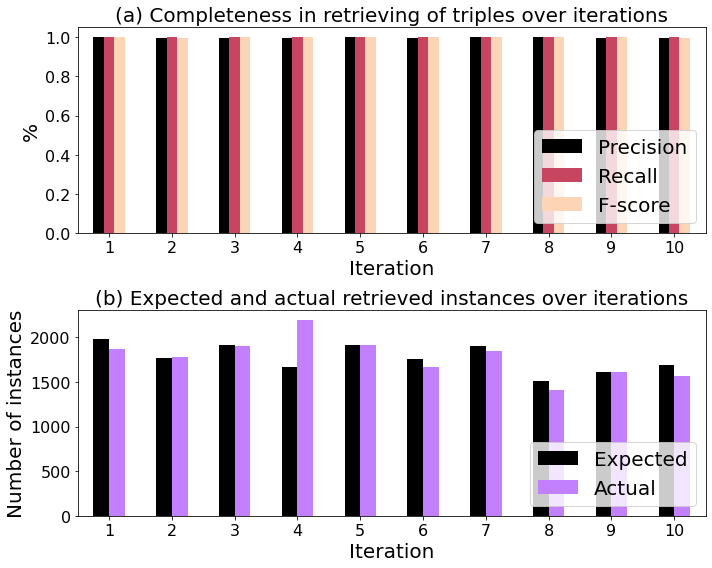

In [39]:
labelsize = 16
fontsize = 20

fig, ax_some = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Precision, Recall, F-score
ax1 = df_completeness.plot.bar(xlabel='Iteration', rot=0, color=['k', '#C74560', '#fcd4b6'], ax=ax_some[0]);
ax1.legend(["Precision", "Recall", "F-score"], loc='lower right', fontsize=fontsize)
ax1.set_title('(a) Completeness in retrieving of triples over iterations', fontsize=fontsize)
ax1.set_xlabel("Iteration", fontsize=fontsize)
ax1.set_ylabel('%', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks(np.arange(10), np.arange(1, 11));

ax2 = df_stats[['expected_num_instances', 'retrieved_num_instances']].plot.bar(rot=0, color=['k', '#c280ff'], ax=ax_some[1]);
ax2.legend(["Expected", "Actual"], loc='lower right', fontsize=fontsize)
ax2.set_title('(b) Expected and actual retrieved instances over iterations', fontsize=fontsize)
ax2.set_xlabel("Iteration", fontsize=fontsize)
ax2.set_ylabel('Number of instances', fontsize=fontsize)
ax2.tick_params(labelsize=labelsize)
ax2.set_xticks(np.arange(10), np.arange(1, 11));

plt.tight_layout()

# fig.savefig('../data/dbpedia_completeness.png')
# fig.savefig('../data/wikidata_completeness.png')

## Performance

- computation time
- number of executed queries
- number of processed class types
- clustering validation, DBCV

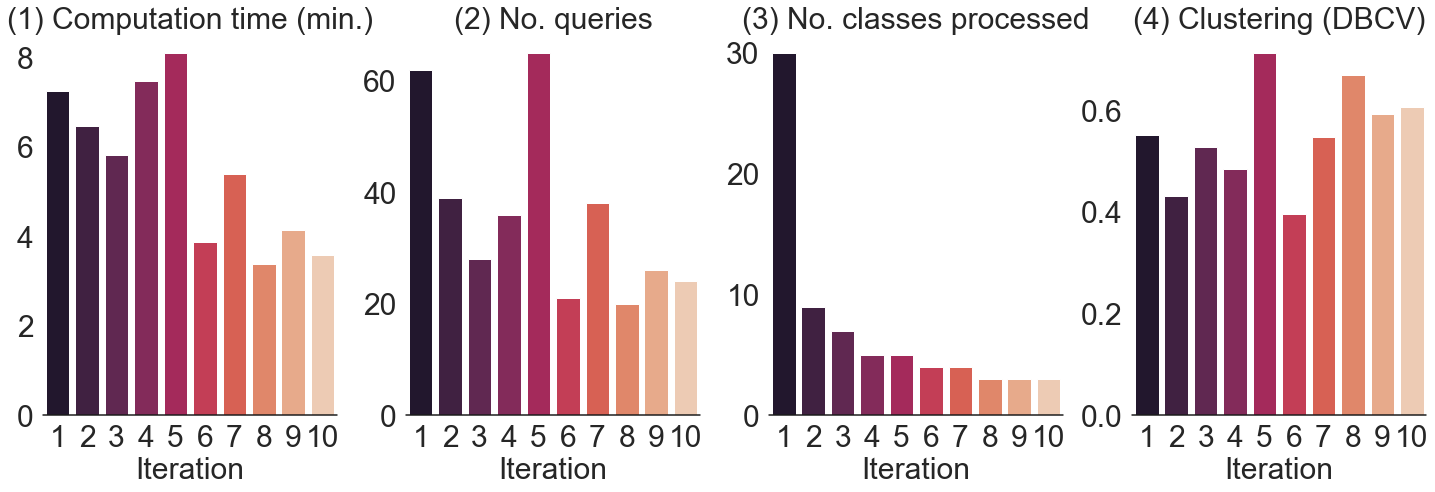

In [57]:
sns.set_theme(style="white")

df_stats['elapsed_time_m'] = df_stats.elapsed_time_s / 60
df_stats.elapsed_time_m = df_stats.elapsed_time_m.apply(lambda x: round(x, 2))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7), sharex=True)

labelsize = 30
fontsize = 30

x = df_stats.batch_id + 1
y1 = df_stats.elapsed_time_m
sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_title("(1) Computation time (min.)", fontsize=fontsize)
ax1.set_xlabel("Iteration", fontsize=fontsize)
ax1.set_ylabel("")
ax1.tick_params(labelsize=labelsize)

y2 = df_stats.total_n_queries
sns.barplot(x=x, y=y2, palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_title("(2) No. queries", fontsize=fontsize)
ax2.set_xlabel("Iteration", fontsize=fontsize)
ax2.set_ylabel("")
ax2.tick_params(labelsize=labelsize)

y3 = df_stats.processed_explicit_classes
s3 = sns.barplot(x=x, y=y3, palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_title("(3) No. classes processed", fontsize=fontsize)
ax3.set_xlabel("Iteration", fontsize=fontsize)
ax3.set_ylabel("")
ax3.tick_params(labelsize=labelsize)

y4 = df_stats.validity_index
sns.barplot(x=x, y=y4, palette="rocket", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_title("(4) Clustering (DBCV)", fontsize=fontsize)
ax4.set_xlabel("Iteration", fontsize=fontsize)
ax4.set_ylabel("")
ax4.tick_params(labelsize=labelsize)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

sns.despine(left=True, bottom=True)

fig = f.get_figure()
# fig.savefig("../data/performance_dbpedia.png")
# fig.savefig("../data/performance_wikidata.png")

## Summary of all 10 iterations

Total summary of all 10 iterations

In [4]:
df_dbpedia = pd.read_csv('../data/dbpedia_batch_1_10_55min_213_explicit_4168_implicit_stats.csv')
df_wikidata = pd.read_csv('../data/wikidata_batch_1_10_1h2min_1161_explicit_2286_implicit_stats.csv')

In [5]:
df_d = pd.DataFrame({
    'total_triples': [df_dbpedia['total_visited_triples'].sum()],
    'total_used_triples': [df_dbpedia['total_visited_triples'].sum() - df_dbpedia['total_removed_triples'].sum()],
    'total_n_queries': [df_dbpedia['total_n_queries'].sum()],
    'total_computation_time_minutes': [round(df_dbpedia['elapsed_time_s'].sum() / 60, 2)],
    'total_processed_classes': [df_dbpedia['processed_explicit_classes'].sum()],
    'total_expected_instances': [df_dbpedia['expected_num_instances'].sum()],
    'total_actual_instances': [df_dbpedia['retrieved_num_instances'].sum()],
    'total_num_patterns': [df_dbpedia['num_distinct_patterns'].sum()],
    'total_explicit_class': [213], # a measure after deduplication right after obtaining all iterations, see "Deduplication of nodes after running for 10 iterations"
    'total_implicit_class': [4168], # a measure after deduplication right after obtaining all iterations, see "Deduplication of nodes after running for 10 iterations"
    'mean_dbcv': [round(df_dbpedia['validity_index'].mean(), 2)]
}, index=['DBpedia']).transpose()

In [6]:
df_w = pd.DataFrame({
    'total_triples': [df_wikidata['total_visited_triples'].sum()],
    'total_used_triples': [df_wikidata['total_visited_triples'].sum() - df_wikidata['total_removed_triples'].sum()],
    'total_n_queries': [df_wikidata['total_n_queries'].sum()],
    'total_computation_time_minutes': [round(df_wikidata['elapsed_time_s'].sum() / 60, 2)],
    'total_processed_classes': [df_wikidata['processed_explicit_classes'].sum()],
    'total_expected_instances': [df_wikidata['expected_num_instances'].sum()],
    'total_actual_instances': [df_wikidata['retrieved_num_instances'].sum()],
    'total_num_patterns': [df_wikidata['num_distinct_patterns'].sum()],
    'total_explicit_class': [1161], # a measure after deduplication right after obtaining all iterations, see "Deduplication of nodes after running for 10 iterations"
    'total_implicit_class': [2286], # a measure after deduplication right after obtaining all iterations, see "Deduplication of nodes after running for 10 iterations"
    'mean_dbcv': [round(df_wikidata['validity_index'].mean(), 2)]
}, index=['Wikidata']).transpose()

In [7]:
pd.concat([df_d, df_w], axis=1)

,DBpedia,Wikidata
total_triples,3485027.00,5667473.00
total_used_triples,3479228.00,5577431.00
total_n_queries,359.00,114.00
total_computation_time_minutes,55.45,62.57
total_processed_classes,73.00,1164.00
total_expected_instances,17717.00,19596.00
total_actual_instances,17762.00,19360.00
total_num_patterns,13392.00,9186.00
total_explicit_class,213.00,1161.00
total_implicit_class,4168.00,2286.00
